<a href="https://colab.research.google.com/github/DannyTheFlower/PDA_Course/blob/main/labs/lab_3/PDA_L3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Загрузка данных и способы улучшить результат

1. Поэкспериментируем с различными скоростями обучения. Иногда меньшая скорость обучения может помочь модели сходиться более плавно. Можно попробовать планировщики скорости обучения, которые регулируют скорость обучения во время тренировки.

2. Текущий размер пакета равен 32. В зависимости от вычислительных ресурсов можно попробовать увеличить или уменьшить его, чтобы посмотреть, влияет ли это на производительность модели.

3. Для достижения лучшего результата может потребоваться больше эпох, особенно если скорость обучения низкая.

4. Можно настроить относительный вес.

In [1]:
!mkdir /root/.kaggle
!touch /root/.kaggle/kaggle.json
!echo '{"username":"daniilpiatygo","key":"6a5c15c37176a5dd0af08791f3882e69"}' > /root/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d kanametov/ph2dataset

 98% 198M/203M [00:01<00:00, 175MB/s]
100% 203M/203M [00:01<00:00, 153MB/s]


In [3]:
!unzip -q ph2dataset.zip

In [4]:
import random
import matplotlib.pyplot as plt

In [5]:
from skimage.io import imread, imshow
import os

images = []
lesions = []
BASE_DIR = "/content/PH2Dataset/PH2_Dataset"

for root, dirs, files in os.walk(BASE_DIR):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

In [ ]:
print(f"Количество изображений: {len(images)}")

Количество изображений: 200


In [ ]:
from skimage.transform import resize

size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

Аугментация данных помогает улучшить обобщающую способность модели, делая ее менее чувствительной к вариациям в данных. Параметры:

* ToPILImage(): преобразует тензор изображения в изображение формата PIL (Python Imaging Library).
* RandomHorizontalFlip(): случайное горизонтальное отражение (флип) изображения.
* RandomVerticalFlip(): случайное вертикальное отражение (флип) изображения.
* RandomRotation(20): случайное вращение изображения на угол до 20 градусов.
* ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1): случайное изменение яркости, контраста, насыщенности и оттенка изображения.
* ToTensor(): преобразует изображение формата PIL обратно в тензор.

In [ ]:
from torchvision import transforms
from torchvision.transforms import functional as TF

image_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
])

# без изменений цвета
mask_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
])

# Улучшение качества сегментации

Разделим данные (200 изображений) на тренировочные, тестовые и валидационные в отношении 100/50/50 и инициализируем DataLoader'ы.

In [ ]:
%%capture
!pip install segmentation_models_pytorch torchmetrics

In [ ]:
import torch
from torch.utils.data import DataLoader, random_split, TensorDataset
import torch.nn as nn
import torch.optim as optim

import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from torchmetrics.classification import BinaryJaccardIndex

In [ ]:
class AugmentedDataset(torch.utils.data.Dataset):
    def __init__(self, images, masks, image_transforms, mask_transforms):
        self.images = images
        self.masks = masks
        self.image_transforms = image_transforms
        self.mask_transforms = mask_transforms

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index]
        mask = self.masks[index]

        # Случайно применяем трансформации к изображению и маске
        seed = torch.randint(0, 2**32, ())
        torch.manual_seed(seed)
        image = self.image_transforms(image)
        torch.manual_seed(seed)
        mask = self.mask_transforms(mask)

        return image, mask

Здесь мы добавили ещё один гиперпараметр:

**Weight Decay (Регуляризация весов):** добавляет штраф к большим значениям весов модели. Это помогает предотвратить переобучение модели. Значение 1e-5 означает, что штраф будет небольшим, но все же внесет вклад в стабилизацию весов.

In [ ]:
epochs = 30
lr = 0.001
batch_size = 52
weight_decay=1e-5

In [ ]:
import numpy as np

X = np.stack(X).astype(np.float32)
Y = np.stack(Y).astype(np.float32)
Y = (Y > 0.5).astype(np.float32)

X_tensor = torch.tensor(X).permute(0, 3, 1, 2)
Y_tensor = torch.tensor(Y).unsqueeze(1)

augmented_dataset = AugmentedDataset(X_tensor, Y_tensor, image_transforms, mask_transforms)
dataset = TensorDataset(X_tensor, Y_tensor)
train_size = 100
test_size = 50
val_size = 50
train_dataset, val_dataset, test_dataset = random_split(augmented_dataset, [train_size, val_size, test_size])

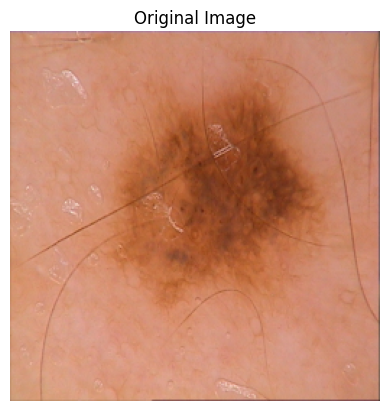

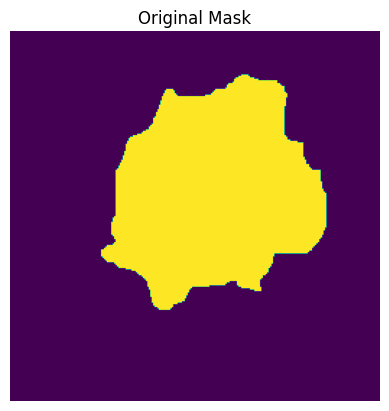

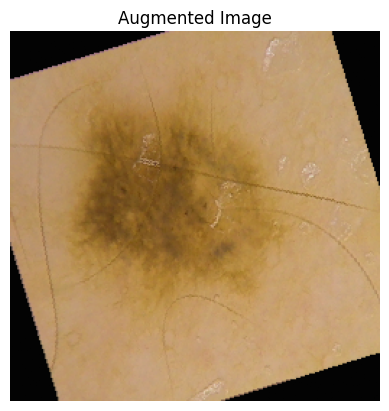

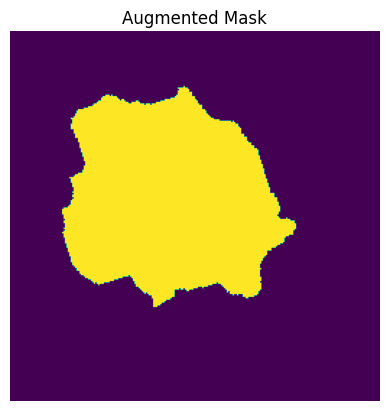

In [ ]:
def show_image(image_tensor, title=''):
    # Преобразуем тензор в NumPy массив для отображения
    image_numpy = image_tensor.permute(1, 2, 0).numpy()
    # Если изображение в градациях серого, убедимся, что matplotlib знает об этом
    if image_numpy.shape[2] == 1:
        image_numpy = image_numpy.squeeze()
    plt.imshow(image_numpy)
    plt.title(title)
    plt.axis('off')

random_idx = random.randint(0, len(augmented_dataset) - 1)
image, mask = augmented_dataset[random_idx]
show_image(X_tensor[random_idx], title='Original Image')
plt.show()
show_image(Y_tensor[random_idx], title='Original Mask')
plt.show()
show_image(image, title='Augmented Image')
plt.show()
show_image(mask, title='Augmented Mask')
plt.show()

Такой подход гарантирует, что при каждой новой эпохе обучения модель увидит немного измененный вариант каждого изображения, что улучшает обобщающую способность модели и помогает предотвратить переобучение.

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

In [ ]:
metric = BinaryJaccardIndex()

In [ ]:
encoder = "timm-efficientnet-b0"
weights = "imagenet"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
metric.to(device)

BinaryJaccardIndex()

In [ ]:
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel, self).__init__()

        self.architecture = smp.Unet(
            encoder_name = encoder,
            encoder_weights=weights,
            in_channels=3,
            classes=1,
            activation=None
        )

    def forward(self, images, masks=None):
        logits = self.architecture(images)

        if masks is not None:
            loss1 = DiceLoss(mode="binary")(logits, masks)
            loss2 = nn.BCEWithLogitsLoss()(logits, masks)
            return logits, loss1+loss2

        return logits

In [ ]:
model = SegmentationModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 158MB/s]


Чтобы реализовать планировщики скорости обучения, которые регулируют скорость обучения во время тренировки, используем модуль torch.optim.lr_scheduler от PyTorch, который предоставляет несколько методов для настройки скорости обучения в зависимости от количества периодов или на основе результатов проверки.

StepLR: Уменьшает скорость обучения каждой группы параметров на гамма каждые эпохи step_size.


In [ ]:
from torch.optim import lr_scheduler

scheduler = lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.095)

In [ ]:
def train_model():
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            logits, loss = model(images, masks)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        if isinstance(scheduler, lr_scheduler.ReduceLROnPlateau):
            scheduler.step(val_loss)
        else:
            scheduler.step()

        train_loss /= len(train_loader)

        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                logits, loss = model(images, masks)
                val_loss += loss.item()

            val_loss /= len(val_loader)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, LR: {optimizer.param_groups[0]['lr']}")

In [ ]:
def eval_model():
    model.eval()

    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = torch.sigmoid(outputs) > 0.5
            metric(preds.int(), masks.int())

    return metric.compute().item()

In [ ]:
def predict(image):
    image_resized = resize(image, size, mode="constant", anti_aliasing=True)
    x = torch.tensor([image_resized]).float().permute(0, 3, 1, 2).to(device)

    model.eval()
    with torch.no_grad():
        output = model(x)
        preds = torch.sigmoid(output) > 0.5

    return preds.squeeze(0).permute(1, 2, 0).cpu()

In [ ]:
train_model()

Epoch 1/30, Train Loss: 1.3374, Val Loss: 1.3708, LR: 0.001
Epoch 2/30, Train Loss: 1.0014, Val Loss: 1.1341, LR: 0.001
Epoch 3/30, Train Loss: 0.7846, Val Loss: 1.0648, LR: 0.001
Epoch 4/30, Train Loss: 0.6117, Val Loss: 0.5692, LR: 0.001
Epoch 5/30, Train Loss: 0.4957, Val Loss: 0.5662, LR: 0.001
Epoch 6/30, Train Loss: 0.4006, Val Loss: 0.6374, LR: 0.001
Epoch 7/30, Train Loss: 0.3463, Val Loss: 0.5130, LR: 0.001
Epoch 8/30, Train Loss: 0.3048, Val Loss: 0.4308, LR: 0.001
Epoch 9/30, Train Loss: 0.2776, Val Loss: 0.3370, LR: 0.001
Epoch 10/30, Train Loss: 0.2539, Val Loss: 0.3140, LR: 0.001
Epoch 11/30, Train Loss: 0.2271, Val Loss: 0.2844, LR: 0.001
Epoch 12/30, Train Loss: 0.2119, Val Loss: 0.2515, LR: 0.001
Epoch 13/30, Train Loss: 0.1910, Val Loss: 0.2290, LR: 0.001
Epoch 14/30, Train Loss: 0.1763, Val Loss: 0.2188, LR: 0.001
Epoch 15/30, Train Loss: 0.1708, Val Loss: 0.2150, LR: 9.5e-05
Epoch 16/30, Train Loss: 0.1672, Val Loss: 0.2065, LR: 9.5e-05
Epoch 17/30, Train Loss: 0.16

Оценим качество модели.

In [ ]:
eval_model()

0.906715989112854

<ipython-input-23-7dcd929377d3>:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  x = torch.tensor([image_resized]).float().permute(0, 3, 1, 2).to(device)


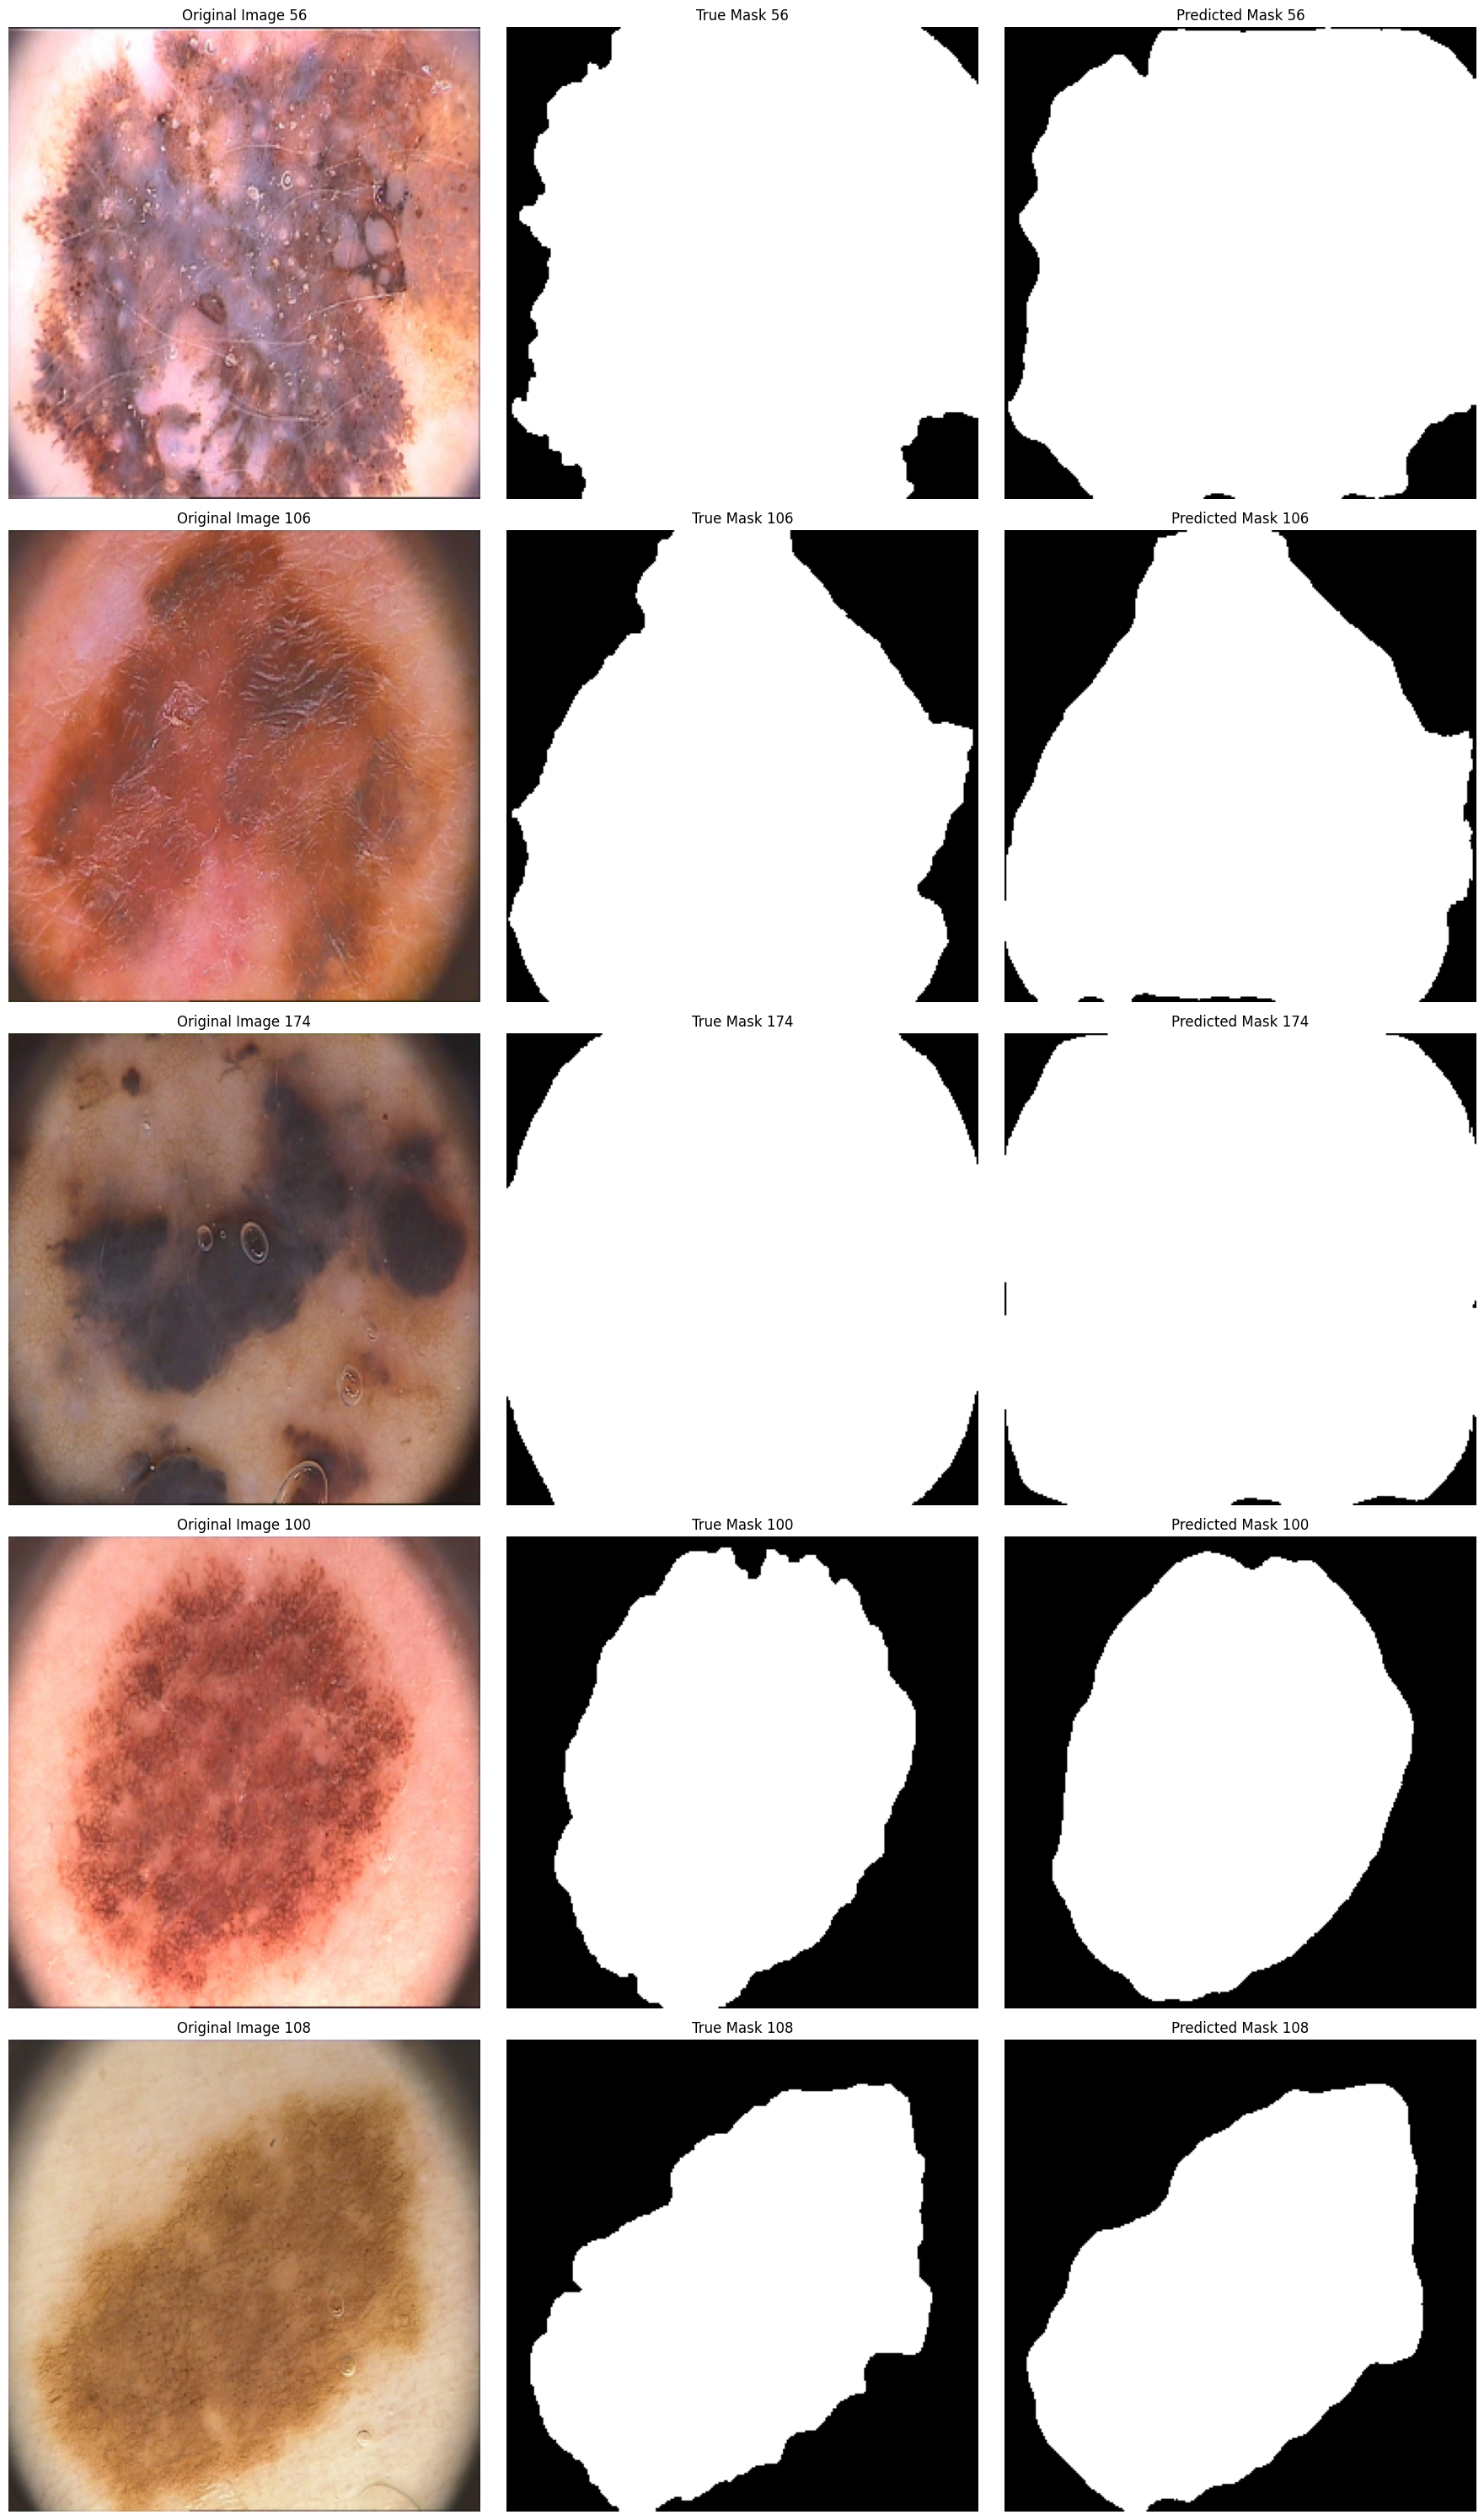

In [ ]:
size = (256, 256)

random_indices = random.sample(range(len(images)), 5)

fig, axes = plt.subplots(5, 3, figsize=(18, 30))

for i, idx in enumerate(random_indices):
    img = resize(images[idx], size, mode="constant", anti_aliasing=True)
    mask_true = resize(lesions[idx], size, mode="constant", anti_aliasing=False)
    mask_pred = predict(img)

    axes[i, 0].imshow(img)
    axes[i, 0].set_title(f"Original Image {idx}")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(mask_true, cmap="gray")
    axes[i, 1].set_title(f"True Mask {idx}")
    axes[i, 1].axis("off")

    axes[i, 2].imshow(mask_pred, cmap="gray")
    axes[i, 2].set_title(f"Predicted Mask {idx}")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()

Результат действительно улучшился!

# Постановка задачи классификации

Помимо масок родинок и меланом, датасет содержит дополнительную информацию в таблице `PH2_dataset.xlsx`. Для классификации типа повреждения нам необходимо использовать признак `Clinical Diagnosis` (в самой таблице он разделён на три признака: `Common Nevus`, `Atypical Nevus`, `Melanoma`), в котором:

*   `Common Nevus` и `Atypical Nevus` (классы 0 и 1) — родинки,
*   `Melanoma` (класс 2) — меланома.

Задача — дообучить сильную нейросеть для классификации родинок и меланом.

In [6]:
import numpy as np
import pandas as pd

In [7]:
df = pd.read_excel('/content/PH2Dataset/PH2_dataset.xlsx', engine='openpyxl', skiprows=12)

In [8]:
df.head()

Image Name Histological Diagnosis Common Nevus Atypical Nevus Melanoma  \
0     IMD003                    NaN            X            NaN      NaN   
1     IMD009                    NaN            X            NaN      NaN   
2     IMD016                    NaN            X            NaN      NaN   
3     IMD022                    NaN            X            NaN      NaN   
4     IMD024                    NaN            X            NaN      NaN   

   Asymmetry\n(0/1/2) Pigment Network\n(AT/T) Dots/Globules\n(A/AT/T)  \
0                   0                       T                       A   
1                   0                       T                       A   
2                   0                       T                       T   
3                   0                       T                       A   
4                   0                       T                       A   

  Streaks\n(A/P) Regression Areas\n(A/P) Blue-Whitish Veil\n(A/P) White  Red  \
0              A                       A                        A   NaN  NaN   
1              A                       A                        A   NaN  NaN   
2              A                       A                        A   NaN  NaN   
3              A                       A                        A   NaN  NaN   
4              A                       A                        A   NaN  NaN   

  Light-Brown Dark-Brown Blue-Gray Black  
0         NaN          X       NaN   NaN  
1           X        NaN       NaN   NaN  
2           X          X       NaN   NaN  
3           X        NaN       NaN   NaN  
4           X          X       NaN   NaN

Оставим только два признака: `Image Name` и `Is Melanoma`.

In [9]:
df['Is Melanoma'] = np.where(df['Melanoma'] == 'X', 1, 0)
df = df[['Image Name', 'Is Melanoma']]

In [10]:
df.head()

Image Name  Is Melanoma
0     IMD003            0
1     IMD009            0
2     IMD016            0
3     IMD022            0
4     IMD024            0

Инициализируем датасет для PyTorch.

In [11]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

In [16]:
# Гиперпараметры
batch_size = 42
lr = 0.001
num_epochs = 15
weight_decay=1e-5

 Подготовим датасет для обучения нейронной сети, включая определение структуры датасета и преобразование изображений.

In [12]:
class MelanomaDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.annotations = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_name = self.annotations.iloc[idx, 0]
        img_path = os.path.join(self.root_dir, img_name, img_name + "_Dermoscopic_Image", img_name + ".bmp")
        image = Image.open(img_path)
        label = self.annotations.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = MelanomaDataset(df, BASE_DIR, transform)

Далее разделим датасет на тренировочный, тестовый и валидационный.

In [13]:
from sklearn.model_selection import train_test_split

train_dataset, test_dataset = train_test_split(dataset, test_size=50, random_state=42)
train_dataset, val_dataset = train_test_split(train_dataset, test_size=50, random_state=42)

Поскольку классы несбалансированы, можно выполнить сэмплинг.

In [14]:
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import WeightedRandomSampler

labels = [label for _, label in train_dataset]

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
sample_weights = [class_weights[label] for label in labels]

sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

In [17]:
train_loader = DataLoader(train_dataset, batch_size, sampler=sampler, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

Попробуем дообучать модель ResNet152. Эта модель была предварительно обучена на большом наборе данных, таком как ImageNet, и содержит выученные признаки.

In [18]:
import torchvision.models as models
import torch.nn as nn

model = models.resnet152(pretrained=True)

# Заменяем последний полносвязный слой
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:04<00:00, 60.1MB/s]


Получается количество входных признаков (num_ftrs) для последнего полносвязного слоя модели. Это количество равно количеству выходных признаков предыдущего слоя.
Создается новый линейный слой с количеством входных признаков num_ftrs и с двумя выходными нейрономи для задачи бинарной классификации.

Разморозим последние два слоя для точной настройки. Этот блок представляет собой последний этап обработки входных данных перед классификацией.

In [19]:
for param in model.layer4.parameters():
    param.requires_grad = True

In [20]:
import torch.optim as optim
import torch

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

In [21]:
%%capture
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [22]:
from torch.optim import lr_scheduler

scheduler = lr_scheduler.StepLR(optimizer, step_size=9, gamma=0.1)

In [23]:
def train_resnet():
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        scheduler.step()

        model.eval()
        with torch.no_grad():
            total = 0
            correct = 0
            val_loss = 0.0
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)

                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        running_loss /= len(train_loader)
        val_loss /= len(val_loader)
        val_accuracy = correct / total

        print(f"Epoch {epoch+1}, Train Loss: {running_loss}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy},  LR: {optimizer.param_groups[0]['lr']}")

In [24]:
def eval_resnet():
    model.eval()
    with torch.no_grad():
        total = 0
        correct = 0
        test_loss = 0.0
        test_accuracy = 0.0
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_loss /= len(test_loader)
        test_accuracy = correct / total
    return test_loss, test_accuracy

In [25]:
train_resnet()

Epoch 1, Train Loss: 0.525523841381073, Validation Loss: 0.7480091154575348, Validation Accuracy: 0.86,  LR: 0.001
Epoch 2, Train Loss: 0.875550360729297, Validation Loss: 2.836089849472046, Validation Accuracy: 0.5,  LR: 0.001
Epoch 3, Train Loss: 0.41402867436408997, Validation Loss: 24.710925102233887, Validation Accuracy: 0.2,  LR: 0.001
Epoch 4, Train Loss: 0.26331515858570737, Validation Loss: 1.3823273181915283, Validation Accuracy: 0.56,  LR: 0.001
Epoch 5, Train Loss: 0.1470003401239713, Validation Loss: 0.8399934321641922, Validation Accuracy: 0.66,  LR: 0.001
Epoch 6, Train Loss: 0.09167932718992233, Validation Loss: 0.6745548918843269, Validation Accuracy: 0.66,  LR: 0.001
Epoch 7, Train Loss: 0.08877650772531827, Validation Loss: 0.23142236463490917, Validation Accuracy: 0.8,  LR: 0.001
Epoch 8, Train Loss: 0.036029777800043426, Validation Loss: 0.21132039721123874, Validation Accuracy: 0.84,  LR: 0.001
Epoch 9, Train Loss: 0.037287663047512375, Validation Loss: 0.21480223

In [27]:
eval_resnet()[1]

0.9


In [29]:
def visualize_prediction(model, device, data_loader, idx):
    model.eval()

    images, labels = next(iter(data_loader))
    image, label = images[idx], labels[idx]

    image = image.to(device).unsqueeze(0)
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
        predicted = predicted.item()

    plt.imshow(image.cpu().squeeze().permute(1, 2, 0))
    plt.title(f"True Label: {label}\nPredicted Label: {predicted}")
    plt.axis('off')
    plt.show()

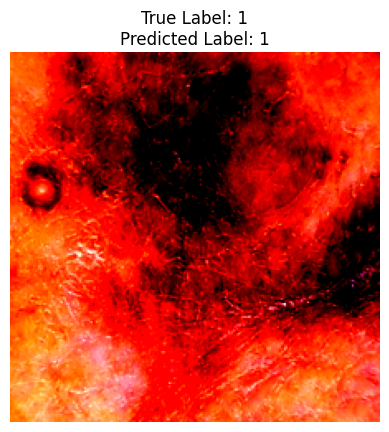

In [31]:
visualize_prediction(model, device, train_loader, 0)

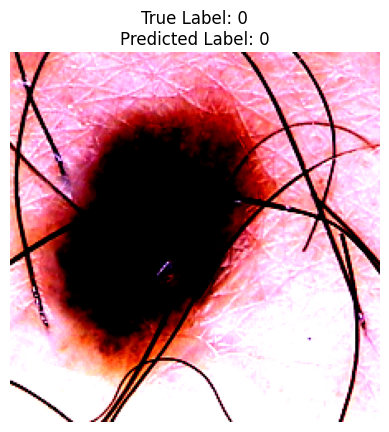

In [32]:
visualize_prediction(model, device, test_loader, 0)

Дообученная на 100 экземплярах нейросеть дала точность 90%. В медицинских целях её использовать, конечно, небезопасно, однако baseline очень неплохой.